In [1]:
import pandas as pd
import random
import os
import glob
import re
from bs4 import BeautifulSoup
from near_regex import NEAR_regex
from tqdm import tqdm
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

## Some notes about missing files before we start
- Of the 505 firms listed in the wikipedia list for S&P500 firms, some of the firms did not file 10-Ks for the year 2019. For some it was because they had different corporate entities so they filed under some other ticker/CIK. Here is a summary of how 10-Ks were obtained.
- Firms not obtained using ticker symbol:
    - Count: 13
    - BBWI
    - BRK.B
    - BF.B
    - PARA
    - LUMN
    - VTRS
    - SBNY
    - OTIS
    - OGN
    - FRC
    - CEG
    - CARR
    - CCL
- Of these, 6 were downloaded using CIK:
    - CCL
    - BBWI
    - BRK.B
    - BF.B
    - PARA
    - LUMN
- The rest could not be downloaded due to filing dates falling outside of the range we are using for our analysis in this project. Some firms filed later in 2020, but if we use those ranges, we obtain 2020 10-Ks for other firms and it gets messy quickly.

In [2]:
# load the sp500 accounting+risk measures dataset
sp500 = pd.read_csv("input/sp500_firms.csv")
sp500a =pd.read_csv("output/sp500_accting_plus_textrisks.csv")
# drop some columns we don't need so we can see some columns we need (some pre-EDA cleaning =) )
sp500a = sp500a.drop(columns=['Unnamed: 0','gvkey','_merge','SEC filings','Headquarters Location','Date first added', 'Founded'])
ccm = pd.read_stata("https://github.com/LeDataSciFi/ledatascifi-2022/blob/main/data/2019%20ccm_cleaned.dta?raw=true")
ccm
# load the 2019-2020 return data from the input foler
ccm_ret = pd.read_stata('input/2019-2020-stock_rets cleaned.dta')
# convert the dates into date fromat
ccm_ret['date'] = pd.to_datetime(ccm_ret['date'].astype(str), format='%Y%m%d')
# convert non-integer and empty return values to 0
ccm_ret.loc[ccm_ret['ret'] == '', 'ret'] = 0.0
ccm_ret.loc[ccm_ret['ret'] == 'C', 'ret'] = 0.0
ccm_ret.loc[ccm_ret['ret'] == 'B', 'ret'] = 0.0
ccm_ret['ret_f']=ccm_ret['ret'].astype(float) #convert ret to float
ccm_ret = ccm_ret.drop(columns=['ret']) # ret_f replaces the ret column
#ccm_ret
# merge this dataset with the dataset containing sp500 accounting+risk measures dataset
sp500b = sp500a.merge(ccm_ret, left_on="Symbol", right_on="ticker", indicator='exists', validate="one_to_many")
# add a new column to the merged dataset that includes the week for each date (we have 52 weeks for the returns we are analyzing)
sp500b = sp500b.assign(week=sp500b['date'].dt.isocalendar().week)
# the sp500b dataset is the basis of our analysis 
# and contains the accounting data, risk measures and daily returns for 355 SP500 firms

## Description of Risk Measures
- Legal risks: This was chosen as a risk measure as it can be interpreted in multiple different ways, with different terms relating to different subcategories of legal risk. The 3 I measure here are Litigation Risk (LIT_exposure), Contractual Risks (CONT_exposure) and Non-Contractual Risks (NCR_exposure).
    - LIT_exposure 
        - This measure of risk uses keywords relevant to a specific type of legal risk known as litigation risk. The number of occurrences of words such as '(lawsuit|court|settle|legal|litigation)' being within a 10-word distance of '(payout|risk|violation|breach)' found using near_regex() is used as the risk measure. The risk of being sued, having to pay out sums of money as settlements etc can affect investor confidence, especially when the future is less certain (as was the climate at the beginning of the pandemic).
        - This measure aims to capture specifically litigation risk and see how that relates to returns around the onset of the pandemic. Did firms who mentioned litigation-related risks in their 10-Ks experience lower returns than those that did not? Does this speak to lower/higher investor-confidence in a firm due to the extent of its exposure to litigation risks (if, for instance, firms with a higher risk measure experience relative lower returns during the first week of the pandemic)?
        - Statistical properties: 276 out of the 355 firms we had requisite data for had some score for this risk measure. The values for these range from 0-8, with a mean of 1.72, median of 1.0 and std of 1.63.
    - CONT_exposure
        - This measure of risk uses keywords relevant to a specific type of legal risk known as contractual risk. The number of occurrences of words such as '(legal|contract|terms|liabilities)' being within a 10-word distance of '(breach|penalty|risk|failure)' found using near_regex() is used as the risk measure. Contractual risk is incurred when there is some failure in fulfillment of contractual liabilities. Failure to meet terms of the contract, failure to provide services in compliance with the contract, failure to include risk mitigating clauses in the contract.
        - This measure aims to capture specifically contractual risk and see how that relates to returns around the onset of the pandemic. Did firms who mentioned contractual risks more in their 10-Ks experience lower returns than those that did not? Does this speak to lower/higher investor-confidence in a firm due to the extent of its exposure to contractual risks (if, for instance, firms with a higher risk measure experience relative lower returns during the first week of the pandemic)?
        - Statistical properties: 326 out of the 355 firms we had requisite data for had some score for this risk measure. The values for these range from 0-21, with a mean of 3.594, median of 3.0 and std of 2.974.
    - NCR_exposure
        - This measure of risk uses keywords relevant to a specific type of legal risk known as non-contractual risk. The number of occurrences of words such as '(copyright|trademark|patent|intellectual property)' being within a 10-word distance of '(risk|violation|breach|infringe|misrepresent)' found using near_regex() is used to measure the risk. Non-contractual risks represent certain damages caused to the competitor due to infringement of copyright or trademark done by your entity in the due course of your business proceedings.
        - This measure aims to capture specifically non-contractual risk and see how that relates to returns around the onset of the pandemic.
        - Statistical properties: 191 out of the 355 firms we had requisite data for had some score for this risk measure. The values for these range from 0-12, with a mean of 1.34 median of 1 and std of 1.92.
- Supply-chain risks: The most difficult challenge to business throughout the COVID-19 pandemic has been supply chain management. The number of occurrences of '(supply|supply chain|raw materials|sourcing)' and '(shortage|recall|delay)' within a 10-word range found using near_regex() is the risk measure. This measure aims to see whether firms who mentioned supply chain risks more before the pandemic were more exposed to these risks. We can see how the value of the measure correlates to the return for that firm. Statistical properties: 63 out of the 355 firms had some value for this risk measure. The values for these range from 0-5, with a mean of 0.25, median of 0 and std of 0.63.
- COVID-19 Risk: This is an experimental measure of risk. Using near_regex() to count the number of occurrences of '(coronavirus|covid|sars-cov|pandemic)' and '(challenge|issue|problem|threat|susceptible|risk|pose)' within a 25-word distance as the measure, the aim is to see which firms saw and mentioned the risks related to the pandemic. We could then see their returns to see if they were more or less affected by the onset of the pandemic. Statistical properties: 31 out of the 355 firms had some value for this risk measure. The values ranged from 0-3 with a mean of 0.113, median of 0 and std of 0.395.
  

In [3]:
sp500a
print('Count of non zeros in LIT_exposure : ', (sp500a['LIT_exposure'] != 0).sum())
print('Count of non zeros in CONT_exposure : ', (sp500a['CONT_exposure'] != 0).sum())
print('Count of non zeros in NCR_exposure : ', (sp500a['NCR_exposure'] != 0).sum())
print('Count of non zeros in SC_exposure : ', (sp500a['SC_exposure'] != 0).sum())
print('Count of non zeros in COV_exposure : ', (sp500a['COV_exposure'] != 0).sum())
print(sp500a[["LIT_exposure", "CONT_exposure", "NCR_exposure", "SC_exposure", "COV_exposure"]].describe())

Count of non zeros in LIT_exposure :  276
Count of non zeros in CONT_exposure :  326
Count of non zeros in NCR_exposure :  191
Count of non zeros in SC_exposure :  63
Count of non zeros in COV_exposure :  31
       LIT_exposure  CONT_exposure  NCR_exposure  SC_exposure  COV_exposure
count    355.000000     355.000000    355.000000   355.000000    355.000000
mean       1.723944       3.594366      1.340845     0.250704      0.112676
std        1.630350       2.974272      1.922038     0.630414      0.395929
min        0.000000       0.000000      0.000000     0.000000      0.000000
25%        1.000000       2.000000      0.000000     0.000000      0.000000
50%        1.000000       3.000000      1.000000     0.000000      0.000000
75%        2.000000       5.000000      2.000000     0.000000      0.000000
max        8.000000      21.000000     12.000000     5.000000      3.000000


## Validation Checks 
- These measures are likely valid. However, there are some caveats. For instance, the COV_exposure measure is experimental as it seeks to measure how many firms proactively mentioned COVID-19 as a source of possible problems/threats and uses a number of terms that may coincidentally be within range. Examples of this include "problem", "threat", "issue", all of which can be used in a variety of ways. Words such as "susceptible", "pose" or "threat" could be more relevant. I wanted the measure to take into account a wide variety of words. There are also only 31 firms that have non zero values for this measure, meaning that there are very few actual cases where this occurs, making it harder to evaluate as a true measure of risk.
- The legal risk measures had the highest rate of occurrences (non-zero values among the firms). Since they each specific to a type of risk, they have different rates of occurrences. These are all likely valid because there are specific terms that apply to each category of legal risk. For instance, when talking about "copyright", firms are much more likely to be referring to non-contractual risk than contractual risks. Also words such as "infringe" are less likely to be used when talking about contractual risk compared to non-contractual risk. The only issues when measuring using near_regex() maybe the number of words between the firms. 10 may be too high or low, depending on a particular sentence (we will see examples of this below)

### Matches
In explore_ugly.ipynb, some NEAR_regex() matches were printed for each risk. 

The following table consists of examples of matches for each risk measure (the code can be found in explore_ugly.ipynb)

| Risk Measure|Example Matches| Firm        | 
| ----------- | ----------- | ----------- |
| LIT_exposure|   [('', '', 'risk', 'litigation')]     |    ABMD         |
|    |[('', '', 'risk', 'legal'), ('legal', 'violation', '', ''), ('', '', 'risk', 'litigation')]   |  ACN  |
| CONT_exposure|  [('', '', 'risk', 'terms'), ('', '', 'risk', 'liabilities'), ('', '', 'breach', 'contract')]     |    MMM         |
|    |[('liabilities', 'failure', '', ''), ('', '', 'breach', 'terms')]   |  ABMD  |
| NCR_exposure|  [('', '', 'infringe', 'intellectual property')]     |    MMM         |
|    |[('intellectual property', 'infringe', '', ''), ('', '', 'infringe', 'intellectual property')]   |  ACN  |
| SC_exposure|   [('', '', 'delay', 'supply'), ('supply', 'delay', '', '')]     |    AOS         |
|    |[('', '', 'shortage', 'supply')]   |  ABMD  |
| COV_exposure|  [('pandemic', 'risk', '', '')]     |    CVX         |
|    | [('', '', 'threat', 'pandemic')]   |  CMG  |

- SC_exposure measures supply chain risk and is quite straightforward. A 10-word distance may again be too low or high depending on the sentence, but the firms with the highest risk score intuitively make sense. This is because companies that mention '(supply|supply chain|raw materials|sourcing)' and '(shortage|recall|delay)' together are obviously more concerned with supply chain risks and are likely to be heavily reliant on their supply chains for a majority of their business. Firms that had the highest SC_exposure risk values included Coca-Cola, Wabtec, Seagate etc. Most of the companies belong to Industrials, Information Technology, Health Care, Energy, Consumer Discretionary and Consumer Staples sectors. This makes sense intuitively because firms belonging to these sectors are in fact heavily reliant on global supply chains, which, if affected, pose serious risk to the firms' business. Check the following output of firms sorted by highest measure of SC_exposure.

In [4]:
sp500a.sort_values(by='SC_exposure', ascending=False)

Symbol    Security             GICS Sector  \
77      KO   Coca-Cola        Consumer Staples   
340    WAB      Wabtec             Industrials   
291    STX     Seagate  Information Technology   
34    ANET      Arista  Information Technology   
224   MRNA     Moderna             Health Care   
..     ...         ...                     ...   
130    FDX       FedEx             Industrials   
129   FAST    Fastenal             Industrials   
128    FDS     FactSet              Financials   
126    XOM  ExxonMobil                  Energy   
354    ZTS      Zoetis             Health Care   

                              GICS Sub-Industry      CIK  SC_exposure  \
77                                  Soft Drinks    21344          5.0   
340       Construction Machinery & Heavy Trucks   943452          4.0   
291  Technology Hardware, Storage & Peripherals  1137789          3.0   
34                     Communications Equipment  1596532          3.0   
224                               Biotechnology  1682852          2.0   
..                                          ...      ...          ...   
130                     Air Freight & Logistics  1048911          0.0   
129                           Building Products   815556          0.0   
128                  Financial Exchanges & Data  1013237          0.0   
126                        Integrated Oil & Gas    34088          0.0   
354                             Pharmaceuticals  1555280          0.0   

     COV_exposure  LIT_exposure  CONT_exposure  NCR_exposure  ...        mb  \
77            0.0           5.0            5.0           1.0  ...  3.522742   
340           0.0           2.0            4.0           1.0  ...  1.261699   
291           0.0           1.0            3.0           3.0  ...  2.183781   
34            0.0           0.0            6.0           8.0  ...  4.020779   
224           3.0           1.0            4.0           7.0  ...  4.402403   
..            ...           ...            ...           ...  ...       ...   
130           0.0           1.0            3.0           0.0  ...  1.412708   
129           0.0           1.0            1.0           0.0  ...  5.881304   
128           0.0           1.0            4.0           3.0  ...  7.216963   
126           0.0           1.0            3.0           0.0  ...  1.286264   
354           0.0           6.0            9.0           5.0  ...  6.216815   

       prof_a     ppe_a    cash_a     xrd_a    dltt_a  invopps_FG09  sales_g  \
77   0.137611  0.141351  0.129369  0.000000  0.331404      3.224640      NaN   
340  0.082648  0.087404  0.031894  0.011080  0.228756      0.926347      NaN   
291  0.225774  0.210355  0.253348  0.111536  0.478672      1.971957      NaN   
34   0.200261  0.030355  0.650939  0.110568  0.019837      3.671484      NaN   
224 -0.323828  0.181141  0.694612  0.312258  0.083278      4.156502      NaN   
..        ...       ...       ...       ...       ...           ...      ...   
130  0.157583  0.559326  0.042626  0.000000  0.305443      1.014307      NaN   
129  0.317035  0.333272  0.046028  0.000000  0.129003      5.703049      NaN   
128  0.319547  0.084944  0.247167  0.137617  0.368030      7.009918      NaN   
126  0.087601  0.716087  0.008519  0.003348  0.085392      0.896609      NaN   
354  0.218709  0.184409  0.167518  0.039584  0.529320      6.019250      NaN   

         dv_a  short_debt  
77   0.079242    0.351670  
340  0.004313    0.021606  
291  0.080248    0.000000  
34   0.000000    0.162020  
224  0.000000    0.026363  
..        ...         ...  
130  0.012554    0.054832  
129  0.131214    0.169997  
128  0.064131    0.000000  
126  0.040408    0.413213  
354  0.027198    0.080500  

[355 rows x 48 columns]

- The output ranks firms with highest COV_exposure ratings. It makes sense that the firms that were most concerned with the pandemic before it became a global phenomenon belonged to Health Care, Airlines, Information Technology (particularly "Semiconductors" Sub-Industry), Energy, Materials, Consumer Discretionary (particularly "Hotels, Resorts & Cruise Lines" Sub-Industry) as they felt most exposed to the effects of a potential global pandemic. This very specific, very experimental measure of risk actually captures, to some extent, risk exposure to COVID-19 based on whether firms mention the relevant terms in their 10-K.

In [5]:
sp500a.sort_values(by='COV_exposure', ascending=False)

Symbol                  Security             GICS Sector  \
224   MRNA                   Moderna             Health Care   
228   MPWR  Monolithic Power Systems  Information Technology   
329    UAL           United Airlines             Industrials   
312    TFX                  Teleflex             Health Care   
106   DLTR               Dollar Tree  Consumer Discretionary   
..     ...                       ...                     ...   
119    EOG             EOG Resources                  Energy   
118   ENPH                   Enphase  Information Technology   
117    EMR                   Emerson             Industrials   
116     EA           Electronic Arts  Communication Services   
354    ZTS                    Zoetis             Health Care   

                      GICS Sub-Industry      CIK  SC_exposure  COV_exposure  \
224                       Biotechnology  1682852          2.0           3.0   
228                      Semiconductors  1280452          0.0           2.0   
329                            Airlines   100517          0.0           2.0   
312               Health Care Equipment    96943          0.0           2.0   
106          General Merchandise Stores   935703          0.0           2.0   
..                                  ...      ...          ...           ...   
119  Oil & Gas Exploration & Production   821189          1.0           0.0   
118               Electronic Components  1463101          0.0           0.0   
117   Electrical Components & Equipment    32604          0.0           0.0   
116      Interactive Home Entertainment   712515          0.0           0.0   
354                     Pharmaceuticals  1555280          0.0           0.0   

     LIT_exposure  CONT_exposure  NCR_exposure  ...        mb    prof_a  \
224           1.0            4.0           7.0  ...  4.402403 -0.323828   
228           4.0            2.0           6.0  ...  8.309925  0.122786   
329           1.0            5.0           0.0  ...  1.201453  0.129916   
312           1.0            6.0           3.0  ...  3.293279  0.113476   
106           4.0            2.0           0.0  ...  2.289558  0.178399   
..            ...            ...           ...  ...       ...       ...   
119           0.0            6.0           0.0  ...  1.729985  0.202067   
118           1.0            2.0           3.0  ...  5.128619  0.164542   
117           0.0            1.0           1.0  ...  2.591377  0.192321   
116           1.0            2.0           0.0  ...  3.787274  0.129284   
354           6.0            9.0           5.0  ...  6.216815  0.218709   

        ppe_a    cash_a     xrd_a    dltt_a  invopps_FG09  sales_g      dv_a  \
224  0.181141  0.694612  0.312258  0.083278      4.156502      NaN  0.000000   
228  0.241723  0.476170  0.112672  0.001153      8.037213      NaN  0.070364   
329  0.663892  0.093973  0.000000  0.348045      0.789031      NaN  0.000000   
312  0.086196  0.047717  0.018044  0.310677      3.008507      NaN  0.009957   
106  0.255185  0.031264  0.000000  0.315920      1.950046      NaN  0.000000   
..        ...       ...       ...       ...           ...      ...       ...   
119  0.838732  0.054626  0.000000  0.123662      1.328347      NaN  0.015844   
118  0.054756  0.415170  0.056618  0.157315           NaN      NaN  0.000000   
117  0.177685  0.072889  0.022150  0.208665      2.273168      NaN  0.058984   
116  0.050017  0.607904  0.159987  0.110975      3.548721      NaN  0.000000   
354  0.184409  0.167518  0.039584  0.529320      6.019250      NaN  0.027198   

     short_debt  
224    0.026363  
228    0.532032  
329    0.104597  
312    0.034881  
106    0.000000  
..          ...  
119    0.231621  
118    0.051194  
117    0.252403  
116    0.000000  
354    0.080500  

[355 rows x 48 columns]

## Final sample for tests & EDA
- Our final sample here is the sp500b dataset, which contains all the data we need for our tests and analysis. This dataset includes all the relevant accounting data, the risk measures, the daily returns for **355 firms**, Sector and Sub-industry information, the week number. This makes it extremely flexible. 
- There are multiple entries for each firm to include daily data. This increases the number of observations to **130627**
- I will be using different names such as "sp500c", "sp500e" etc when I perform changes. This is just how I like to do things. They all come from "sp500b"
#### Summary stats and a view of the dataset is shown below:

In [6]:
print(sp500b.describe())
sp500b

                CIK    SC_exposure   COV_exposure   LIT_exposure  \
count  1.306270e+05  130627.000000  130627.000000  130627.000000   
mean   7.690427e+05       0.256861       0.115443       1.696418   
std    5.534430e+05       0.635969       0.399799       1.595862   
min    1.800000e+03       0.000000       0.000000       0.000000   
25%    9.602100e+04       0.000000       0.000000       1.000000   
50%    8.750450e+05       0.000000       0.000000       1.000000   
75%    1.136869e+06       0.000000       0.000000       2.000000   
max    1.757898e+06       5.000000       3.000000       8.000000   

       CONT_exposure   NCR_exposure        lpermno          fyear  \
count  130627.000000  130627.000000  130627.000000  130627.000000   
mean        3.579911       1.339179   53883.440866    2018.886187   
std         2.965733       1.934247   30181.631245       0.317585   
min         0.000000       0.000000   10104.000000    2018.000000   
25%         2.000000       0.000000   1956

Symbol Security  GICS Sector         GICS Sub-Industry      CIK  \
0         MMM       3M  Industrials  Industrial Conglomerates    66740   
1         MMM       3M  Industrials  Industrial Conglomerates    66740   
2         MMM       3M  Industrials  Industrial Conglomerates    66740   
3         MMM       3M  Industrials  Industrial Conglomerates    66740   
4         MMM       3M  Industrials  Industrial Conglomerates    66740   
...       ...      ...          ...                       ...      ...   
130622    ZTS   Zoetis  Health Care           Pharmaceuticals  1555280   
130623    ZTS   Zoetis  Health Care           Pharmaceuticals  1555280   
130624    ZTS   Zoetis  Health Care           Pharmaceuticals  1555280   
130625    ZTS   Zoetis  Health Care           Pharmaceuticals  1555280   
130626    ZTS   Zoetis  Health Care           Pharmaceuticals  1555280   

        SC_exposure  COV_exposure  LIT_exposure  CONT_exposure  NCR_exposure  \
0               0.0           0.0           0.0            3.0           1.0   
1               0.0           0.0           0.0            3.0           1.0   
2               0.0           0.0           0.0            3.0           1.0   
3               0.0           0.0           0.0            3.0           1.0   
4               0.0           0.0           0.0            3.0           1.0   
...             ...           ...           ...            ...           ...   
130622          0.0           0.0           6.0            9.0           5.0   
130623          0.0           0.0           6.0            9.0           5.0   
130624          0.0           0.0           6.0            9.0           5.0   
130625          0.0           0.0           6.0            9.0           5.0   
130626          0.0           0.0           6.0            9.0           5.0   

        ...  ticker      comnam  primexch         prc    shrout    vwretd  \
0       ...     MMM       3M CO         N  153.300003  575600.0  0.044398   
1       ...     MMM       3M CO         N  170.580002  575279.0  0.002394   
2       ...     MMM       3M CO         N  165.169998  575051.0 -0.005643   
3       ...     MMM       3M CO         N  146.399994  575261.0 -0.010146   
4       ...     MMM       3M CO         N  179.779999  575051.0  0.001938   
...     ...     ...         ...       ...         ...       ...       ...   
130622  ...     ZTS  ZOETIS INC         N   85.900002  480451.0  0.004474   
130623  ...     ZTS  ZOETIS INC         N  120.279999  474934.0 -0.096841   
130624  ...     ZTS  ZOETIS INC         N  127.040001  477558.0 -0.007200   
130625  ...     ZTS  ZOETIS INC         N  100.120003  478772.0  0.000550   
130626  ...     ZTS  ZOETIS INC         N  133.229996  474934.0 -0.008552   

             _merge     ret_f  exists  week  
0       matched (3)  0.064140    both    11  
1       matched (3)  0.014874    both    37  
2       matched (3) -0.018423    both    49  
3       matched (3) -0.009338    both    16  
4       matched (3) -0.008767    both     3  
...             ...       ...     ...   ...  
130622  matched (3) -0.003827    both     2  
130623  matched (3) -0.076687    both    11  
130624  matched (3)  0.004904    both    36  
130625  matched (3)  0.011007    both    17  
130626  matched (3) -0.005375    both     9  

[130627 rows x 60 columns]

In [7]:
## More EDA and caveats
# We already dropped some columns from sp500a before merging with ccm_ret to make sp500b
# Here, we are checking for missing values that may cause issues with our analysis
(
    ( # these lines do the calculation - what % of missing values are there for each var
        sp500b.isna()
       .sum(axis=0)
        /len(sp500b)
        *100
    )
    .sort_values(ascending=False)[0:10]
    .to_frame(name='% missing')
    .style.format("{:.1f}")
)
# The table below shows that most/all of the relevant data is present in our data
# There are also more caveats regarding the risk measurements in the description section above

### Exploring the correlation between the risk values and stock returns around key dates for the onset of COVID-19.

In [8]:
# slice the dataset by date
sp500c = sp500b.set_index(['date']).sort_values(by='date',ascending=True)
# Get the firms' daily returns for the week of Mar 9 - Mar 13
sp500c = sp500c.loc["2020-03-09":"2020-03-13"]
sp500c
# 355 firms x 5 trading days' data = 1750 observations in sp500c dataset

Symbol                Security             GICS Sector  \
date                                                                
2020-03-09    LYB          LyondellBasell               Materials   
2020-03-09     MU                  Micron  Information Technology   
2020-03-09   FBHS          Fortune Brands             Industrials   
2020-03-09    ZBH           Zimmer Biomet             Health Care   
2020-03-09    BWA              BorgWarner  Consumer Discretionary   
...           ...                     ...                     ...   
2020-03-13   XRAY         Dentsply Sirona             Health Care   
2020-03-13    ABT                  Abbott             Health Care   
2020-03-13    MAR  Marriott International  Consumer Discretionary   
2020-03-13     IR          Ingersoll Rand             Industrials   
2020-03-13   GRMN                  Garmin  Consumer Discretionary   

                         GICS Sub-Industry      CIK  SC_exposure  \
date                                                               
2020-03-09             Specialty Chemicals  1489393          0.0   
2020-03-09                  Semiconductors   723125          0.0   
2020-03-09               Building Products  1519751          0.0   
2020-03-09           Health Care Equipment  1136869          0.0   
2020-03-09          Auto Parts & Equipment   908255          0.0   
...                                    ...      ...          ...   
2020-03-13            Health Care Supplies   818479          0.0   
2020-03-13           Health Care Equipment     1800          0.0   
2020-03-13  Hotels, Resorts & Cruise Lines  1048286          0.0   
2020-03-13            Industrial Machinery  1699150          0.0   
2020-03-13            Consumer Electronics  1121788          0.0   

            COV_exposure  LIT_exposure  CONT_exposure  NCR_exposure  ...  \
date                                                                 ...   
2020-03-09           0.0           2.0            3.0           0.0  ...   
2020-03-09           0.0           0.0            0.0           0.0  ...   
2020-03-09           0.0           1.0            1.0           0.0  ...   
2020-03-09           0.0           0.0            3.0           0.0  ...   
2020-03-09           0.0           1.0            1.0           1.0  ...   
...                  ...           ...            ...           ...  ...   
2020-03-13           0.0           5.0            4.0           7.0  ...   
2020-03-13           0.0           0.0            0.0           0.0  ...   
2020-03-13           0.0           2.0            2.0           0.0  ...   
2020-03-13           0.0           1.0            2.0           2.0  ...   
2020-03-13           0.0           1.0            1.0           1.0  ...   

            ticker                           comnam  primexch         prc  \
date                                                                        
2020-03-09     LYB    LYONDELLBASELL INDUSTRIES N V         N   59.610001   
2020-03-09      MU            MICRON TECHNOLOGY INC         Q   45.970001   
2020-03-09    FBHS  FORTUNE BRANDS HOME & SECUR INC         N   56.169998   
2020-03-09     ZBH       ZIMMER BIOMET HOLDINGS INC         N  111.260002   
2020-03-09     BWA                   BORGWARNER INC         N   26.049999   
...            ...                              ...       ...         ...   
2020-03-13    XRAY              DENTSPLY SIRONA INC         Q   40.459999   
2020-03-13     ABT              ABBOTT LABORATORIES         N   81.650002   
2020-03-13     MAR   MARRIOTT INTERNATIONAL INC NEW         Q   95.610001   
2020-03-13      IR               INGERSOLL RAND INC         N   23.000000   
2020-03-13    GRMN                       GARMIN LTD         Q   77.339996   

               shrout    vwretd       _merge     ret_f  exists  week  
date                                                                  
2020-03-09   333555.0 -0.079317  matched (3) -0.171968    both    11  
2020-03-09  1112000.0 -0

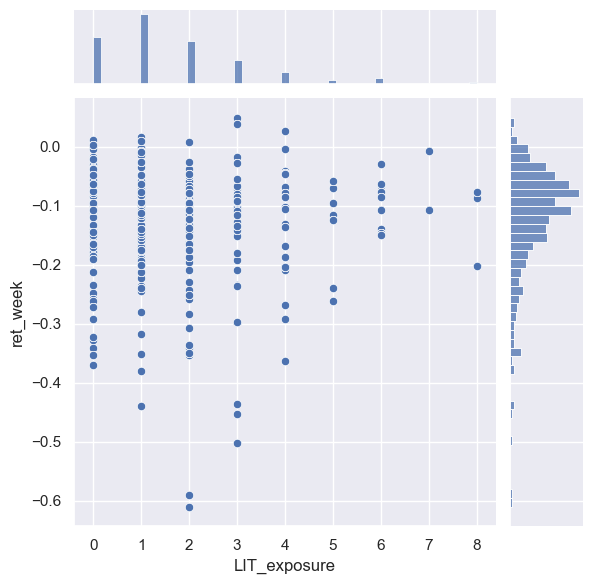

In [9]:
sp500e = sp500c
# weekly return for 3/9 to 3/13
sp500e = (sp500c
                   # compute gross returns for each asset (and get the week var)
                   .assign(ret_week = 1+sp500c['ret_f'])#,
                           #week = sp500c['date'].dt.isocalendar().week)
                   # for each firm
                   .groupby(["Symbol"])
                   # cumulate the returns
                   ['ret_week'].prod()
                   # subtract one
                   -1
             ).to_frame()

sp500e = sp500e.merge(sp500c, left_on="Symbol",right_on="Symbol")
# sp500e has the cumulative return "ret_week" for the week
# Each weekly return value is repeated 5 times for each firm because this dataset also includes daily data
sp500e
# search_mask=["Industrials"]
# sp500e = sp500e[sp500e['GICS Sector'].str.contains('|'.join(search_mask))]
sns.set(rc= {'figure.figsize': (5,5),"figure.dpi":100})
#ax = sns.scatterplot(data=sp500e,x="LIT_exposure",y='ret_week',style="Symbol")
ax = sns.jointplot(x="LIT_exposure",y="ret_week", data=sp500e)
#ax.legend(bbox_to_anchor=(1.02, 0.15), loc="lower left", ncol=3)
#ax.legend([],[], frameon=False)
#ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Litigation Exposure',xlabel='Return',)# xlim=(-1,0.1))

In this section of the analysis, a heavy focus is placed on firms that experienced more than a -20% loss in value. This is because almost all firms experienced a negative return, so simply looking at those firms would not yield any useful insights.
In the figure above if we look at -20% returns for the week, firms with a "LIT_exposure" value >= 1 make up majority of the points on the scatterplot. There are also extreme cases with highly negative returns for firms that have a high "LIT_exposure value. However, the inverse is also true (LIT_exposure = 8, Return > -20%)

[Text(0.5, 1.0, 'Risk and Return (Week 3/9-3/13)'),
 Text(0, 0.5, 'Return'),
 Text(0.5, 0, 'Contractual Exposure')]

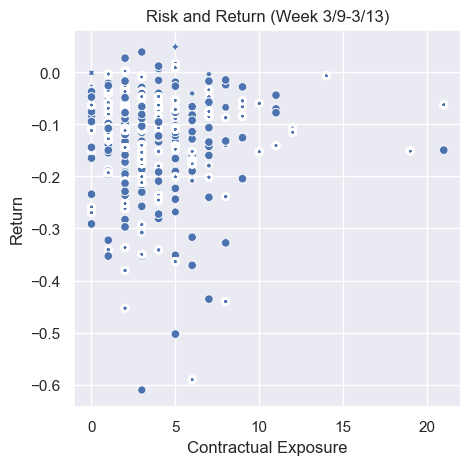

In [10]:
print()
#sns.set(rc= {'figure.figsize': (20,15),"figure.dpi":500})
ax = sns.scatterplot(data=sp500e,y="ret_week",x='CONT_exposure',style="Symbol")
#ax.legend(bbox_to_anchor=(1.02, 0.15), loc="lower left", ncol=3)
plt.legend([],[], frameon=False)
ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Return',xlabel='Contractual Exposure')#, xlim=(-.5,6))

CONT_exposure plotted against return shows that there is some correlation between the two. Majority of the firms with high negative returns (returns less than or equal to 20%), had a non-zero value for CONT_exposure. Furthermore, firms with a value of between 3-10 all experienced -30% return over the week or more. This suggests that a high CONT_exposure value, which indicates that a firm considers their ability to fulfill contractual obligations to be at risk, may be correlated with low investor confidence in times of uncertainty.

[Text(0.5, 1.0, 'Risk and Return (Week 3/9-3/13)'),
 Text(0, 0.5, 'Return'),
 Text(0.5, 0, 'Non-Contractual Exposure')]

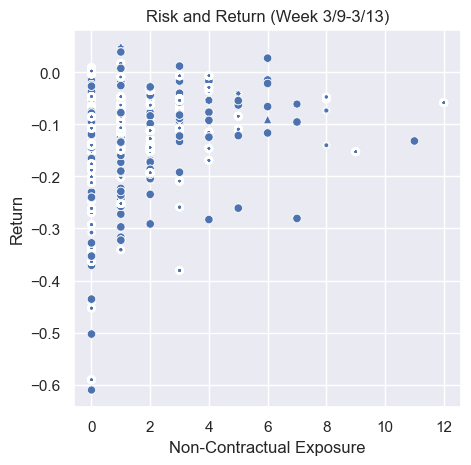

In [11]:
print()
ax = sns.scatterplot(data=sp500e,y="ret_week",x='NCR_exposure',style="Symbol")
#ax.legend(bbox_to_anchor=(1.02, 0.15), loc="lower left", ncol=3)
plt.legend([],[], frameon=False)
ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Return',xlabel='Non-Contractual Exposure')#, xlim=(-.5,6))

The correlation between NCR_exposure and Return seems to be stronger. A large proportion of high negative returns also had high NCR_exposure values

[Text(0.5, 1.0, 'Risk and Return (Week 3/9-3/13)'),
 Text(0, 0.5, 'Return'),
 Text(0.5, 0, 'Supply Chain Risk Exposure')]

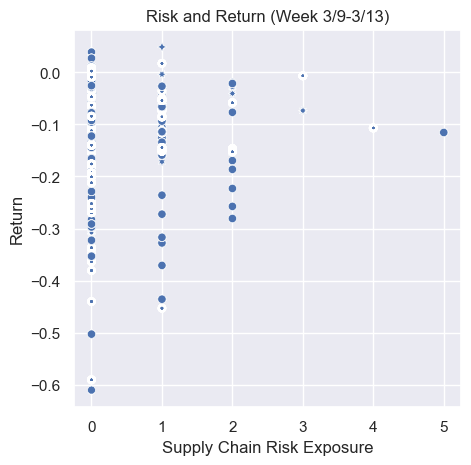

In [12]:
print()
ax = sns.scatterplot(data=sp500e,y="ret_week",x='SC_exposure',style="Symbol")
#ax.legend(bbox_to_anchor=(1.02, 0.15), loc="lower left", ncol=3)
plt.legend([],[], frameon=False)
ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Return',xlabel='Supply Chain Risk Exposure')#, xlim=(-.5,6))

SC_risk and Return also have a strong correlation as a large proportion of high negative returns also had high SC_exposure values. Some firms with high negative returns had no SC_exposure value, but this can be accounted for. For instance, they may have other risks (such as Contractual risk which had a similar firm with a positive CONT_exposure value) or risks that were not measured in this project.

[Text(0.5, 1.0, 'Risk and Return (Week 3/9-3/13)'),
 Text(0, 0.5, 'Return'),
 Text(0.5, 0, 'COVID-19 Risk Exposure')]

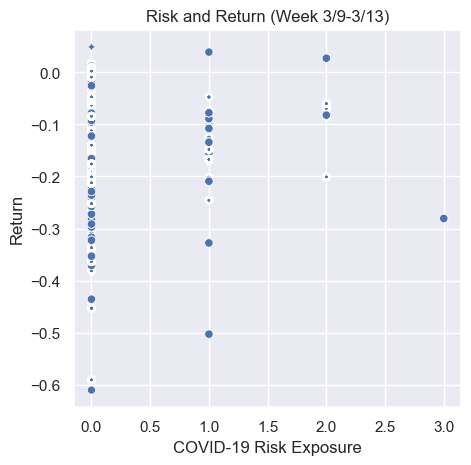

In [13]:
print()
ax = sns.scatterplot(data=sp500e,y="ret_week",x='COV_exposure',style="Symbol")
#ax.legend(bbox_to_anchor=(1.02, 0.15), loc="lower left", ncol=3)
plt.legend([],[], frameon=False)
ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Return',xlabel='COVID-19 Risk Exposure')#, xlim=(-.5,6))

The COV_exposure risk measure does not show a very strong correlation with negative Returns. A majority of the firms that experienced a high negative return over the week (less than or equal to -20%) had a COV_exposure value of 0. However, there were firms that experienced -30%,-50% and ~-28% or -29% returns with COV_exposure values of 1,1, and 3 respectively.

In [14]:
# Additonal visualization of Risk measure and return by industry/sector 
# compute weekly returns for each firm and add to the analysis dataset 
sp500e = sp500c
# weekly return for 3/9 to 3/13
sp500e = (sp500c
                   # compute gross returns for each asset (and get the week var)
                   .assign(R = 1+sp500c['ret_f'])#,
                           #week = sp500c['date'].dt.isocalendar().week)
                   # for each firm
                   .groupby(["Symbol"])
                   # cumulate the returns
                   ['R'].prod()
                   # subtract one
                   -1
             ).to_frame()
#weekly_ret.T.plot()

sp500e = sp500e.merge(sp500c, left_on="Symbol",right_on="Symbol")
search_mask=["Health Care","Industrials"]
sp500e = sp500e[sp500e['GICS Sector'].str.contains('|'.join(search_mask))]
sns.set(rc= {'figure.figsize': (20,15),"figure.dpi":500})
ax = sns.scatterplot(data=sp500e,y="R",x='CONT_exposure',style="GICS Sector",hue="GICS Sub-Industry")

ax.set(title='Risk and Return (Week 3/9-3/13)',ylabel='Return',xlabel='Contractual Exposure')#, xlim=(-.5,6))

[Text(0.5, 1.0, 'Risk and Return (Week 3/9-3/13)'),
 Text(0, 0.5, 'Return'),
 Text(0.5, 0, 'Contractual Exposure')]